In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
reviews_df = pd.read_json("mini-appliances.jsonl", lines=True)
print(reviews_df.head())

   rating                                      title  \
0       1                     Don’t waste your money   
1       3  Does the job in an extremely loud fashion   
2       3              Leaks but company did replace   
3       5                       Good Quality & Handy   
4       5                                 Five Stars   

                                                text  \
0  Got mold on the filter with a weeks worth of u...   
1  The ice machine makes the ice so quickly. But,...   
2  UPDATE :  Contacted company directly since I w...   
3  This frothing pitcher is the perfect size, eas...   
4                        Great OEM and high quality.   

                                              images        asin parent_asin  \
0  [{'small_image_url': 'https://images-na.ssl-im...  B003PEBFU2  B003PEBFU2   
1                                                 []  B08FZYMWJT  B07NVJP82G   
2                                                 []  B01FG2VIRA  B0B1CYSYQ1   
3     

In [4]:
# Classify sentiment based on rating
conditions = [
    (reviews_df['rating'] <= 2),
    (reviews_df['rating'] == 3),
    (reviews_df['rating'] >= 4)
]

sentiment = [
    'negative',
    'neutral',
    'positive'
]

reviews_df['sentiment_label'] = np.select(conditions, sentiment, default='unknown')

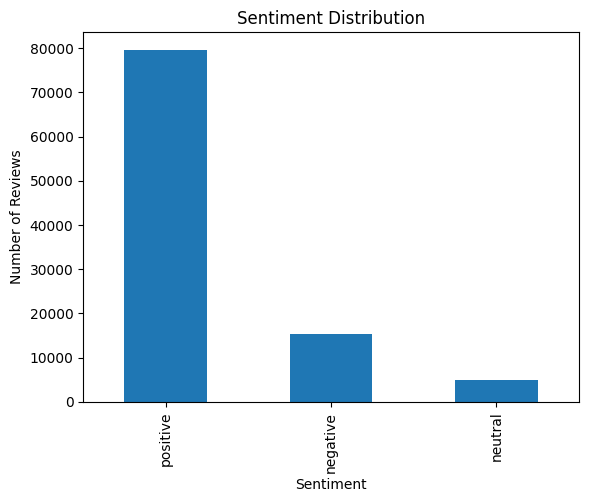

In [5]:
# Visualize sentiment distribution
reviews_df['sentiment_label'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [6]:
# Preprocess text

# Removing stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

reviews_df['title'] = reviews_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Perform lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

reviews_df['title'] = reviews_df['title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Convert to lowercase and remove punctuation
punctuation_pattern = r'[^a-zA-Z0-9\s]'

reviews_df['title'] = reviews_df['title'].str.lower().replace(punctuation_pattern, '', regex=True)
reviews_df['text'] = reviews_df['text'].str.lower().replace(punctuation_pattern, '', regex=True)

# Combine title and text
reviews_df['cleaned_text'] = reviews_df['title'] + ' ' + reviews_df['text']
print(reviews_df[['cleaned_text', 'sentiment_label']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                        cleaned_text sentiment_label
0  dont waste money got mold filter week worth us...        negative
1  does job extremely loud fashion the ice machin...         neutral
2  leaks company replace update  contacted compan...         neutral
3  good quality  handy this frothing pitcher perf...        positive
4                  five stars great oem high quality        positive


In [11]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.0001, max_df=0.8)
X = vectorizer.fit_transform(reviews_df['cleaned_text'])
print(vectorizer.get_feature_names_out()[:20])

y = reviews_df['sentiment_label']

['01' '02' '05' '10' '10 10' '10 12' '10 15' '10 buck' '10 cup' '10 day'
 '10 degree' '10 foot' '10 inch' '10 min' '10 minute' '10 minutes'
 '10 month' '10 months' '10 oz' '10 second']


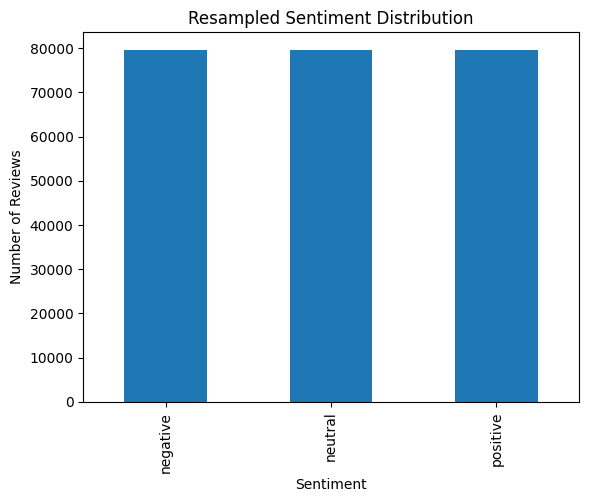

In [12]:
# Oversampling using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Visualize resampled sentiment distribution
pd.Series(y_res).value_counts().plot(kind='bar')
plt.title("Resampled Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# Linear Regression model to predict sentiment based on review text

Accuracy: 0.9681768696089105
Classification Report: 
              precision    recall  f1-score   support

    negative       0.96      0.99      0.97     15921
     neutral       0.96      1.00      0.98     15921
    positive       0.99      0.92      0.95     15922

    accuracy                           0.97     47764
   macro avg       0.97      0.97      0.97     47764
weighted avg       0.97      0.97      0.97     47764



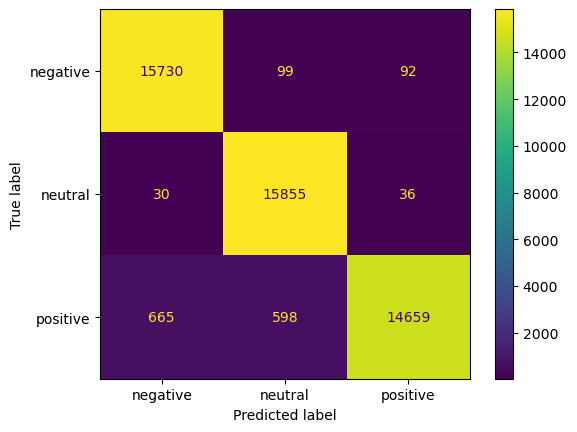

In [ ]:
# Split data into training and testing sets
X_trn, X_tst, y_trn, y_tst = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Tune the Naive Bayes classifier with GridSearch
lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=100, solver='liblinear')

lr.fit(X_trn, y_trn)
y_pred = lr.predict(X_tst)

accuracy = np.mean(y_pred == y_tst)

# Display results
print(f"Accuracy: {accuracy}")

print(f"Classification Report: \n{classification_report(y_tst, y_pred)}")

cm = confusion_matrix(y_tst, y_pred, labels=sentiment)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiment)
disp.plot()
plt.show()

In [7]:
# Tokenize text for neural network model
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(reviews_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(reviews_df['cleaned_text'])
X_pad = pad_sequences(sequences, maxlen=100)

y = to_categorical(reviews_df['rating'] - 1, num_classes=5)

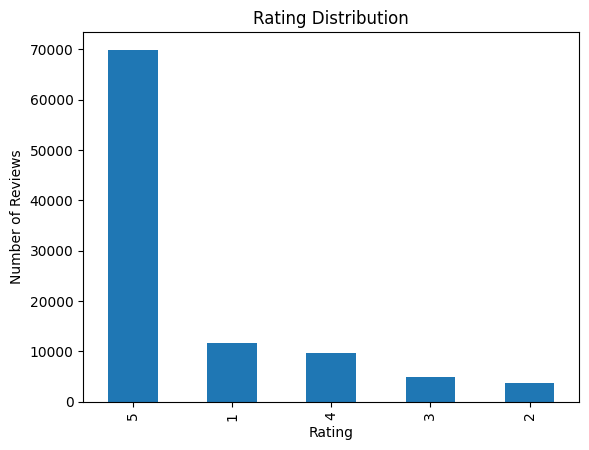

In [8]:
# Visualize rating distribution
pd.Series(reviews_df['rating']).value_counts().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

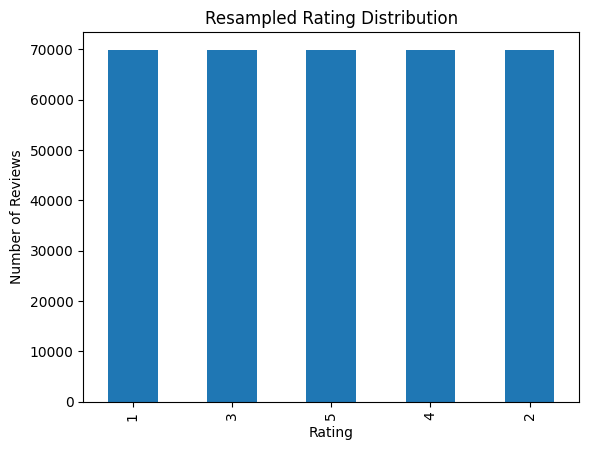

In [18]:
# Oversample ratings using SMOTE
X_res, y_res = sm.fit_resample(X_pad, reviews_df['rating'])

# Visualize resampled sentiment distribution
pd.Series(y_res).value_counts().plot(kind='bar')
plt.title("Resampled Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [19]:
# Split data into train and test sets
X_trn, X_tst, y_trn_int, y_tst_int = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

y_trn = to_categorical(y_trn_int - 1, num_classes=5)
y_tst = to_categorical(y_tst_int - 1, num_classes=5)

# LSTM Model for Rating Prediction

Epoch 1/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 799s 364ms/step - accuracy: 0.2972 - loss: 1.5073 - val_accuracy: 0.3638 - val_loss: 1.3828
Epoch 2/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 785s 359ms/step - accuracy: 0.3755 - loss: 1.3679 - val_accuracy: 0.3974 - val_loss: 1.3229
Epoch 3/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 812s 364ms/step - accuracy: 0.4050 - loss: 1.3076 - val_accuracy: 0.4180 - val_loss: 1.2650
Epoch 4/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 794s 360ms/step - accuracy: 0.4239 - loss: 1.2602 - val_accuracy: 0.4255 - val_loss: 1.2454
Epoch 5/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 783s 358ms/step - accuracy: 0.4325 - loss: 1.2339 - val_accuracy: 0.4316 - val_loss: 1.2295
Epoch 6/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 802s 367ms/step - accuracy: 0.4421 - loss: 1.2134 - val_accuracy: 0.4319 - val_loss: 1.2217
Epoch 7/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 788s 361ms/step - accuracy: 0.4466 - loss: 1.1974 - val_accuracy: 0.4348 - val_loss: 1.2174
Epoch 8/10
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 781s 357ms/step - ac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

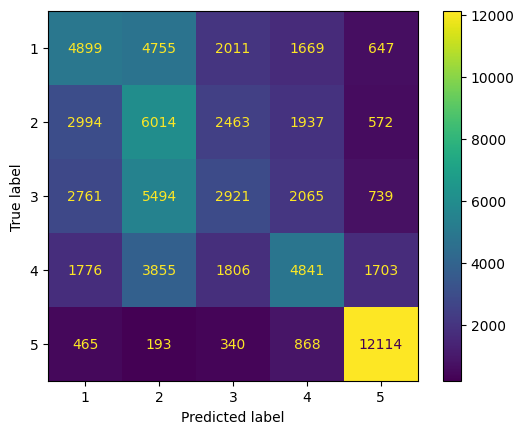

In [27]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=30000, output_dim=100))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Train the model
class_weights = compute_class_weight('balanced', classes=np.unique(y_trn_int), y=y_trn_int)
class_weights = dict(enumerate(class_weights))
history = model.fit(X_trn, y_trn, epochs=10, batch_size=128, validation_data=(X_tst, y_tst), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_tst, y_tst)
print(f"Accuracy: {accuracy}")

y_pred = model.predict(X_tst)
y_pred_classes = y_pred.argmax(axis=1) + 1
y_tst_classes = np.argmax(y_tst, axis=1)
print(f"\nClassification Report: \n{classification_report(y_tst_classes, y_pred_classes)}")

# Confusion matrix
cm = confusion_matrix(y_tst.argmax(axis=1) + 1, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.show()
